In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from constants import *

random_state = 101
path_import_and_export = "../../../Thesis_data/processed_data/"

In [2]:
ontime_reporting_export = pd.read_csv(path_import_and_export + "ontime_reporting_export.csv", dtype=dtypes)

In [16]:
#Check percent of missing data
round(ontime_reporting_export.isnull().sum() * 100 / len(ontime_reporting_export), 2)

MONTH                  0.00
DAY_OF_MONTH           0.00
DAY_OF_WEEK            0.00
OP_UNIQUE_CARRIER      0.00
TAIL_NUM               0.25
ORIGIN_AIRPORT_ID      0.00
ORIGIN_CITY_NAME       0.00
CRS_DEP_TIME           0.00
DEP_DEL15              1.69
CRS_ARR_TIME           0.00
DISTANCE_GROUP         0.00
MANUFACTURE_YEAR       3.66
NUMBER_OF_SEATS        3.66
AWND                   0.01
PRCP                   0.03
SNOW                  29.90
SNWD                  32.26
TMAX                   0.01
MEDIAN_AGE             0.00
TOT_POP                0.00
AVG_HOUSEHOLD_SIZE     0.00
ORIGIN_LAT             0.00
ORIGIN_LONG            0.00
DEST_LAT               0.00
DEST_LONG              0.00
dtype: float64

<AxesSubplot: >

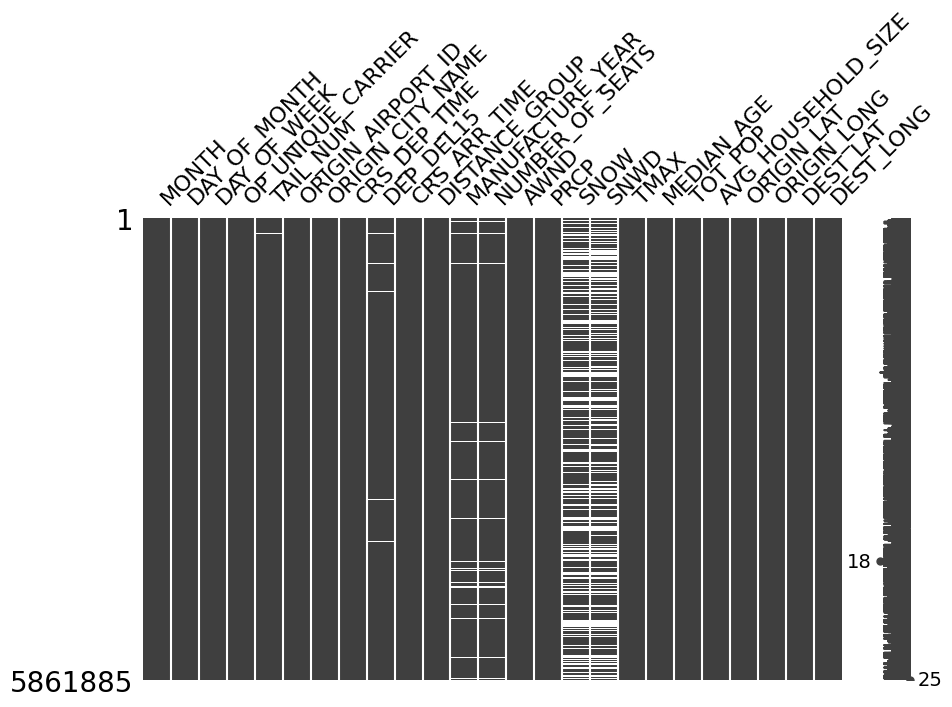

In [17]:
#A matrix to help visualize the missing data and how it correlates per row
msno.matrix(ontime_reporting_export, figsize=(10, 6))

# 1. Cleaning missing data
## 1.1 Cleaning missing: Dependant variable (DEP_DEL15)

In [18]:
#Deleting empty DEP_DEL15 records as this is the target value and imputing doesnt make sense here as it would only introduce noise
ontime_reporting_export = ontime_reporting_export.dropna(subset=['DEP_DEL15'])
round(ontime_reporting_export.isnull().sum() * 100 / len(ontime_reporting_export), 2)

MONTH                  0.00
DAY_OF_MONTH           0.00
DAY_OF_WEEK            0.00
OP_UNIQUE_CARRIER      0.00
TAIL_NUM               0.00
ORIGIN_AIRPORT_ID      0.00
ORIGIN_CITY_NAME       0.00
CRS_DEP_TIME           0.00
DEP_DEL15              0.00
CRS_ARR_TIME           0.00
DISTANCE_GROUP         0.00
MANUFACTURE_YEAR       3.38
NUMBER_OF_SEATS        3.38
AWND                   0.01
PRCP                   0.03
SNOW                  29.94
SNWD                  32.30
TMAX                   0.01
MEDIAN_AGE             0.00
TOT_POP                0.00
AVG_HOUSEHOLD_SIZE     0.00
ORIGIN_LAT             0.00
ORIGIN_LONG            0.00
DEST_LAT               0.00
DEST_LONG              0.00
dtype: float64

## 1.2 Cleaning missing: Weather data

In [19]:
#Replace NA's in columns (SNOW) and (SNWD) with 0 only if both are missing, the assumption is that it did not snow that day
#If one of the two is missing it could be a missing entry and so it will be imputed using MICE in the next code block
#ontime_reporting_export.loc[(ontime_reporting_export['SNOW'].isna()) & (ontime_reporting_export['SNWD'].isna())] = 0.0
temp = (ontime_reporting_export['SNOW'].isna()) & (ontime_reporting_export['SNWD'].isna())
ontime_reporting_export['SNOW'].loc[temp] = 0.0
ontime_reporting_export['SNWD'].loc[temp] = 0.0

round(ontime_reporting_export.isnull().sum() * 100 / len(ontime_reporting_export), 2)

MONTH                 0.00
DAY_OF_MONTH          0.00
DAY_OF_WEEK           0.00
OP_UNIQUE_CARRIER     0.00
TAIL_NUM              0.00
ORIGIN_AIRPORT_ID     0.00
ORIGIN_CITY_NAME      0.00
CRS_DEP_TIME          0.00
DEP_DEL15             0.00
CRS_ARR_TIME          0.00
DISTANCE_GROUP        0.00
MANUFACTURE_YEAR      3.38
NUMBER_OF_SEATS       3.38
AWND                  0.01
PRCP                  0.03
SNOW                  0.17
SNWD                  2.53
TMAX                  0.01
MEDIAN_AGE            0.00
TOT_POP               0.00
AVG_HOUSEHOLD_SIZE    0.00
ORIGIN_LAT            0.00
ORIGIN_LONG           0.00
DEST_LAT              0.00
DEST_LONG             0.00
dtype: float64

In [20]:
#Using a multivariate imputer to fill the other missing weather data using all the relevant columns from that dataset
#In theory this would be the most accurate imputation method as it depends on the other weather feature which would have an influence on the imputed value
#This would be more accurate instead of taking the mean/median/mode
MI_columns = ontime_reporting_export.loc[:, ["AWND", "PRCP", "SNOW", "SNWD", "TMAX"]]

Multivariate_imputer = IterativeImputer(random_state=random_state, max_iter=10)
df_imputed = Multivariate_imputer.fit_transform(MI_columns)

#Replace NA's with imputed values
ontime_reporting_export.loc[:, ["AWND", "PRCP", "SNOW", "SNWD", "TMAX"]] = df_imputed
round(ontime_reporting_export.isnull().sum() * 100 / len(ontime_reporting_export), 2)

MONTH                 0.00
DAY_OF_MONTH          0.00
DAY_OF_WEEK           0.00
OP_UNIQUE_CARRIER     0.00
TAIL_NUM              0.00
ORIGIN_AIRPORT_ID     0.00
ORIGIN_CITY_NAME      0.00
CRS_DEP_TIME          0.00
DEP_DEL15             0.00
CRS_ARR_TIME          0.00
DISTANCE_GROUP        0.00
MANUFACTURE_YEAR      3.38
NUMBER_OF_SEATS       3.38
AWND                  0.00
PRCP                  0.00
SNOW                  0.00
SNWD                  0.00
TMAX                  0.00
MEDIAN_AGE            0.00
TOT_POP               0.00
AVG_HOUSEHOLD_SIZE    0.00
ORIGIN_LAT            0.00
ORIGIN_LONG           0.00
DEST_LAT              0.00
DEST_LONG             0.00
dtype: float64

## 1.3 Cleaning missing: Aircraft inventory data

In [21]:
#Imputing missing MANUFACTURE_YEAR and NUMBER_OF_SEATS data with mean
ontime_reporting_export['MANUFACTURE_YEAR'].fillna((ontime_reporting_export['MANUFACTURE_YEAR'].median()), inplace=True)
ontime_reporting_export['NUMBER_OF_SEATS'].fillna((ontime_reporting_export['NUMBER_OF_SEATS'].median()), inplace=True)

round(ontime_reporting_export.isnull().sum() * 100 / len(ontime_reporting_export), 2)

MONTH                 0.0
DAY_OF_MONTH          0.0
DAY_OF_WEEK           0.0
OP_UNIQUE_CARRIER     0.0
TAIL_NUM              0.0
ORIGIN_AIRPORT_ID     0.0
ORIGIN_CITY_NAME      0.0
CRS_DEP_TIME          0.0
DEP_DEL15             0.0
CRS_ARR_TIME          0.0
DISTANCE_GROUP        0.0
MANUFACTURE_YEAR      0.0
NUMBER_OF_SEATS       0.0
AWND                  0.0
PRCP                  0.0
SNOW                  0.0
SNWD                  0.0
TMAX                  0.0
MEDIAN_AGE            0.0
TOT_POP               0.0
AVG_HOUSEHOLD_SIZE    0.0
ORIGIN_LAT            0.0
ORIGIN_LONG           0.0
DEST_LAT              0.0
DEST_LONG             0.0
dtype: float64

# 2. Exploratory Data Analysis (EDA)

<AxesSubplot: >

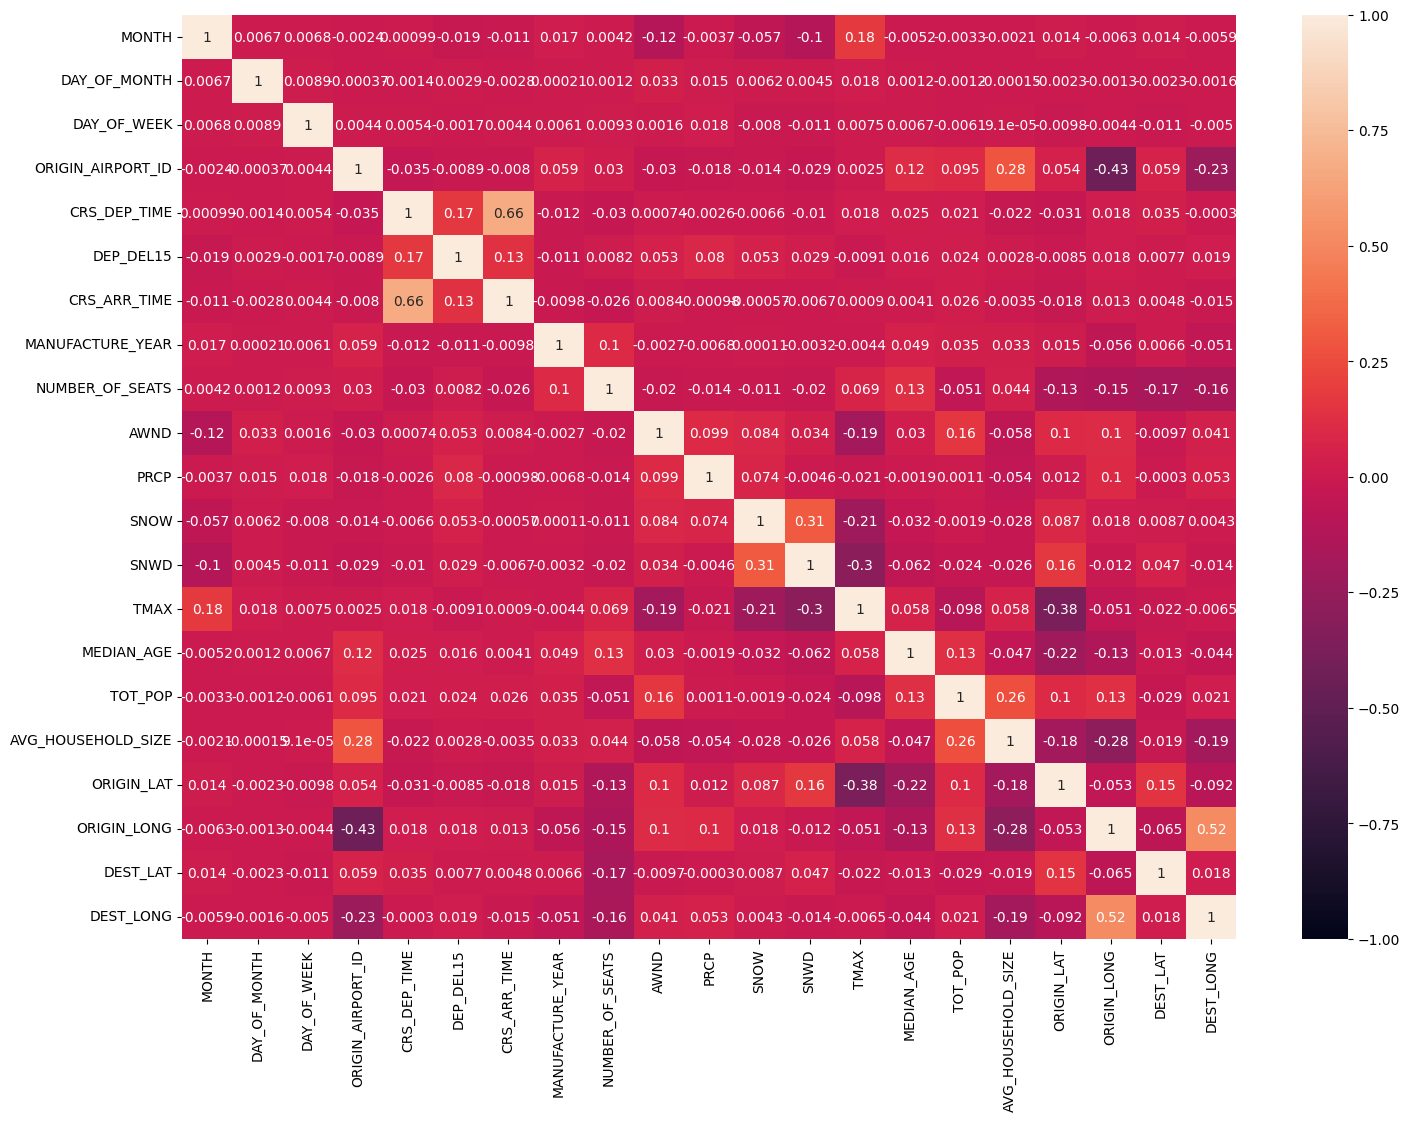

In [23]:
plt.figure(figsize=(17, 12))
sns.heatmap(ontime_reporting_export.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)

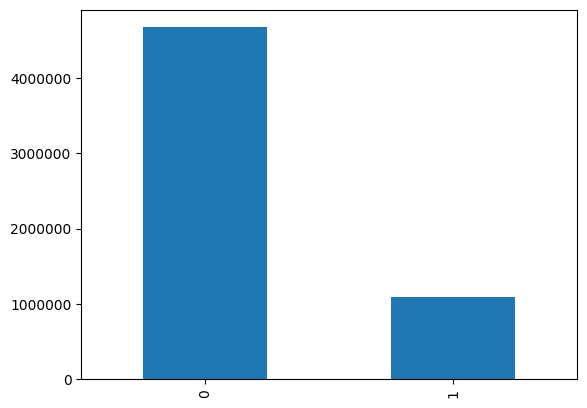

0: 81.09% and 1: 18.91%


In [27]:
plt.ticklabel_format(style='plain')
ontime_reporting_export["DEP_DEL15"] = ontime_reporting_export["DEP_DEL15"].astype("category")
ontime_reporting_export["DEP_DEL15"].value_counts().plot(kind='bar')
plt.show()
print("0: {}% and 1: {}%".format(
    round(len(ontime_reporting_export[ontime_reporting_export.DEP_DEL15 == 0])/len(ontime_reporting_export.DEP_DEL15)*100,2), 
    round(len(ontime_reporting_export[ontime_reporting_export.DEP_DEL15 == 1])/len(ontime_reporting_export.DEP_DEL15)*100,2)
    )
)

In [25]:
def describe(df):
    return pd.concat([df.describe().T,
                      df.skew(numeric_only=True).rename('skew'),
                      df.kurt(numeric_only=True).rename('kurt'),
                      df.median(numeric_only=True).rename('median'),
                     ], axis=1).T

ontime_explained = describe(ontime_reporting_export)
ontime_explained

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,CRS_DEP_TIME,MANUFACTURE_YEAR,NUMBER_OF_SEATS,AWND,PRCP,SNOW,SNWD,TMAX,MEDIAN_AGE,TOT_POP,AVG_HOUSEHOLD_SIZE
count,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0,5900559.0
mean,6.589711,15.71798,3.93421,12661.540142,1342.402271,2007.433219,133.975684,8.302092,0.104868,0.035415,0.111083,70.92165,34.478425,1350893.066091,2.517444
std,3.405903,8.758198,1.994603,1515.76343,495.492162,6.947195,46.273402,3.59918,0.347625,0.33812,0.80329,18.551742,2.062648,1878132.699385,0.286742
min,1.0,1.0,1.0,10140.0,1.0,1987.0,44.0,0.0,0.0,-0.063141,-0.273557,-10.0,29.9,71109.0,2.08
25%,4.0,8.0,2.0,11278.0,920.0,2002.0,90.0,5.82,0.0,0.0,0.0,58.0,33.7,410935.0,2.36
50%,7.0,16.0,4.0,12892.0,1330.0,2007.0,143.0,7.61,0.0,0.0,0.0,74.0,34.2,672228.0,2.51
75%,10.0,23.0,6.0,13930.0,1746.0,2014.0,172.0,10.29,0.03,0.0,0.0,86.0,35.3,1469824.0,2.66
max,12.0,31.0,7.0,15919.0,2359.0,2019.0,337.0,33.78,11.63,17.2,25.2,115.0,42.8,8550405.0,4.58
skew,-0.027117,0.007478,0.050595,0.02999,0.066646,-0.101688,-0.211319,0.977119,9.611784,15.722367,11.496468,-0.545829,1.325611,2.847204,2.708084
kurt,-1.178865,-1.185988,-1.221813,-1.29691,-1.062427,-0.86763,-0.387256,1.506397,191.455349,339.812786,175.667973,-0.2161,3.633149,7.902366,16.79204


In [ ]:
#Looking for high skewness
skew_df = pd.DataFrame(ontime_explained.loc["skew", (ontime_explained.loc["skew",:] < -0.5) | (ontime_explained.loc["skew",:] > 0.5)])
skew_df.T.columns

fig, axs = plt.subplots(2, 5, figsize=(20, 9))  # 2 rows, 5 columns
axs = axs.flatten()

for i, col in enumerate(ontime_reporting_export[skew_df.T.columns]):
    axs[i].hist(ontime_reporting_export[col], bins=12, color='blue', alpha=0.7)
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
#Looking for high kurtosis
kurtosis_cols = ontime_explained.loc["kurt", (ontime_explained.loc["kurt",:] < -3) | (ontime_explained.loc["kurt",:] > 3)]

for col in kurtosis_cols.index:
    plt.subplot(20, 5, len(kurtosis_cols.index))
    plt.hist(ontime_reporting_export[col])
    plt.title(col)

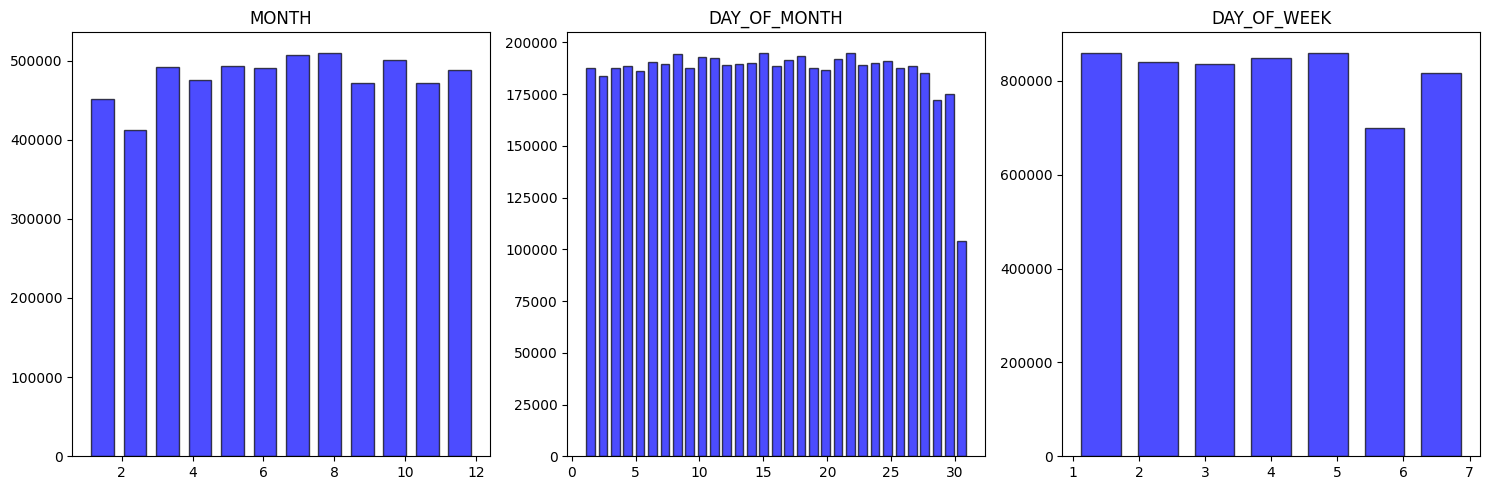

In [28]:
#Visualizing date related distributions
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 rows, 3 columns
axs = axs.flatten()

for i, col in enumerate(ontime_reporting_export.loc[:,["MONTH","DAY_OF_MONTH","DAY_OF_WEEK"]]):
    axs[i].hist(ontime_reporting_export[col], bins=ontime_reporting_export[col].nunique(), color='blue', alpha=0.7, ec='black', rwidth=0.7)
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

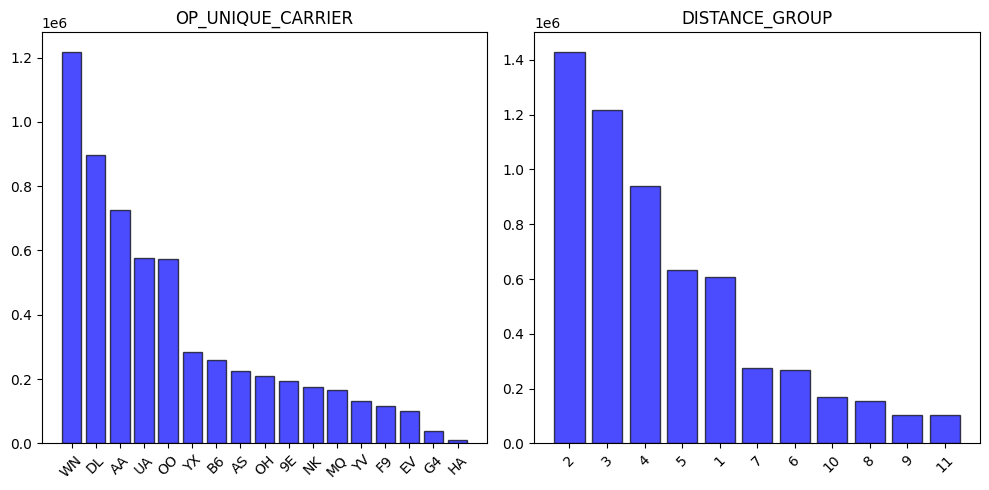

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

columns = ontime_reporting_export.loc[:,["OP_UNIQUE_CARRIER","DISTANCE_GROUP"]]

for i, col in enumerate(columns):
    value_counts = ontime_reporting_export[col].value_counts()
    axs[i].bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, edgecolor='black')
    axs[i].set_title(col)
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

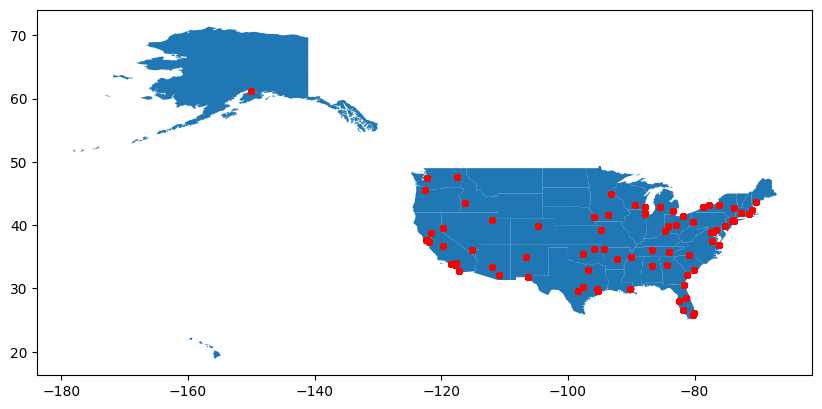

In [12]:
#LONG AND LAT ORGIN AND DEST
origin_coordinates = [Point(xy) for xy in zip(ontime_reporting_export['ORIGIN_LONG'], ontime_reporting_export['ORIGIN_LAT'])]
origin_gdf = GeoDataFrame(ontime_reporting_export, geometry=origin_coordinates)

# Load the US States map
us_states = gpd.read_file("./US States map/States_shapefile.shp")

# Plot both origin and destination GeoDataFrames on the same axes
ax = us_states.plot(figsize=(10, 6))
origin_gdf.plot(ax=ax, marker='o', color='red', markersize=15, label='Destination')

plt.show()

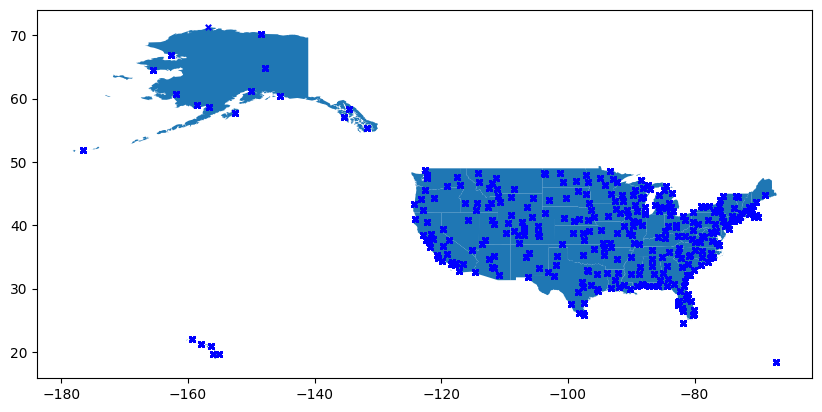

In [10]:
# Create Point objects for DESTINATION coordinates
dest_coordinates = [Point(xy) for xy in zip(ontime_reporting_export['DEST_LONG'], ontime_reporting_export['DEST_LAT'])]
dest_gdf = GeoDataFrame(ontime_reporting_export, geometry=dest_coordinates)

# Load the US States map
us_states = gpd.read_file("./US States map/States_shapefile.shp")

# Plot both origin and destination GeoDataFrames on the same axes
ax = us_states.plot(figsize=(10, 6))
dest_gdf.plot(ax=ax, marker='x', color='blue', markersize=15, label='Destination')

plt.show()

In [ ]:
#CRS_DEP_TIME CRS_ARR_TIME 

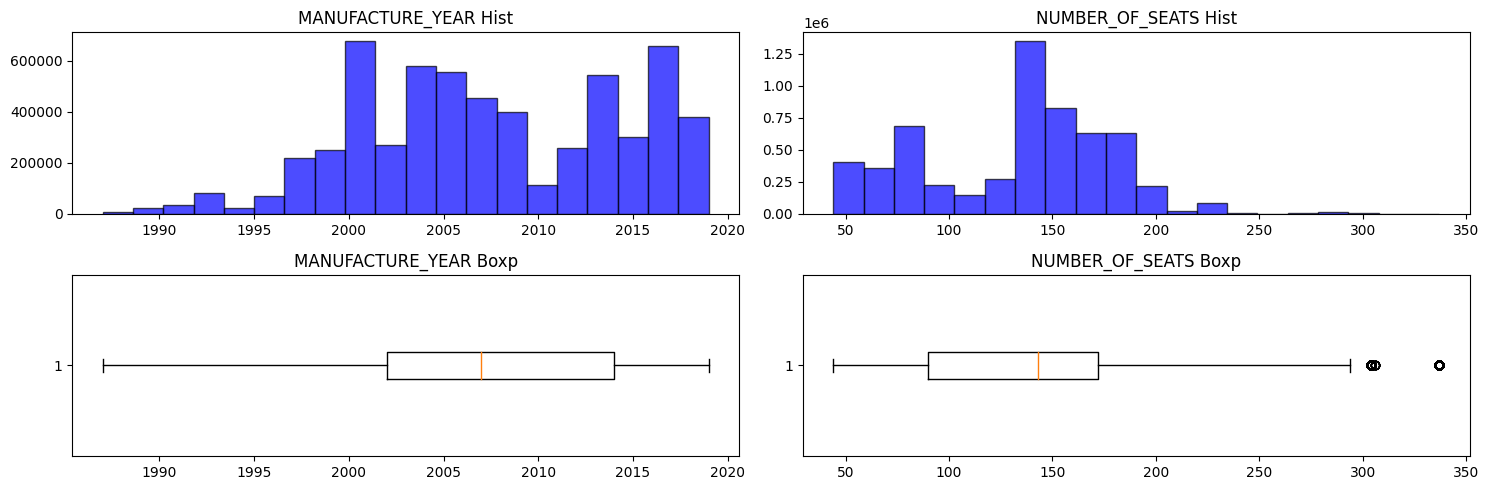

In [21]:
#Visualizing aircraft related distributions + boxplot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(15, 5))  # 2 rows, 2 columns
axs = axs.flatten()

columns = ontime_reporting_export.loc[:,["MANUFACTURE_YEAR","NUMBER_OF_SEATS"]]

for i, col in enumerate(columns):
    axs[i].hist(ontime_reporting_export[col], bins=20, color='blue', alpha=0.7, ec='black')
    axs[i].set_title(col + ' Hist')

for i, col in enumerate(columns):
    axs[i + len(columns.columns)].boxplot(ontime_reporting_export[col], vert=False)
    axs[i + len(columns.columns)].set_title(col + ' Boxp')

plt.tight_layout()
plt.show()

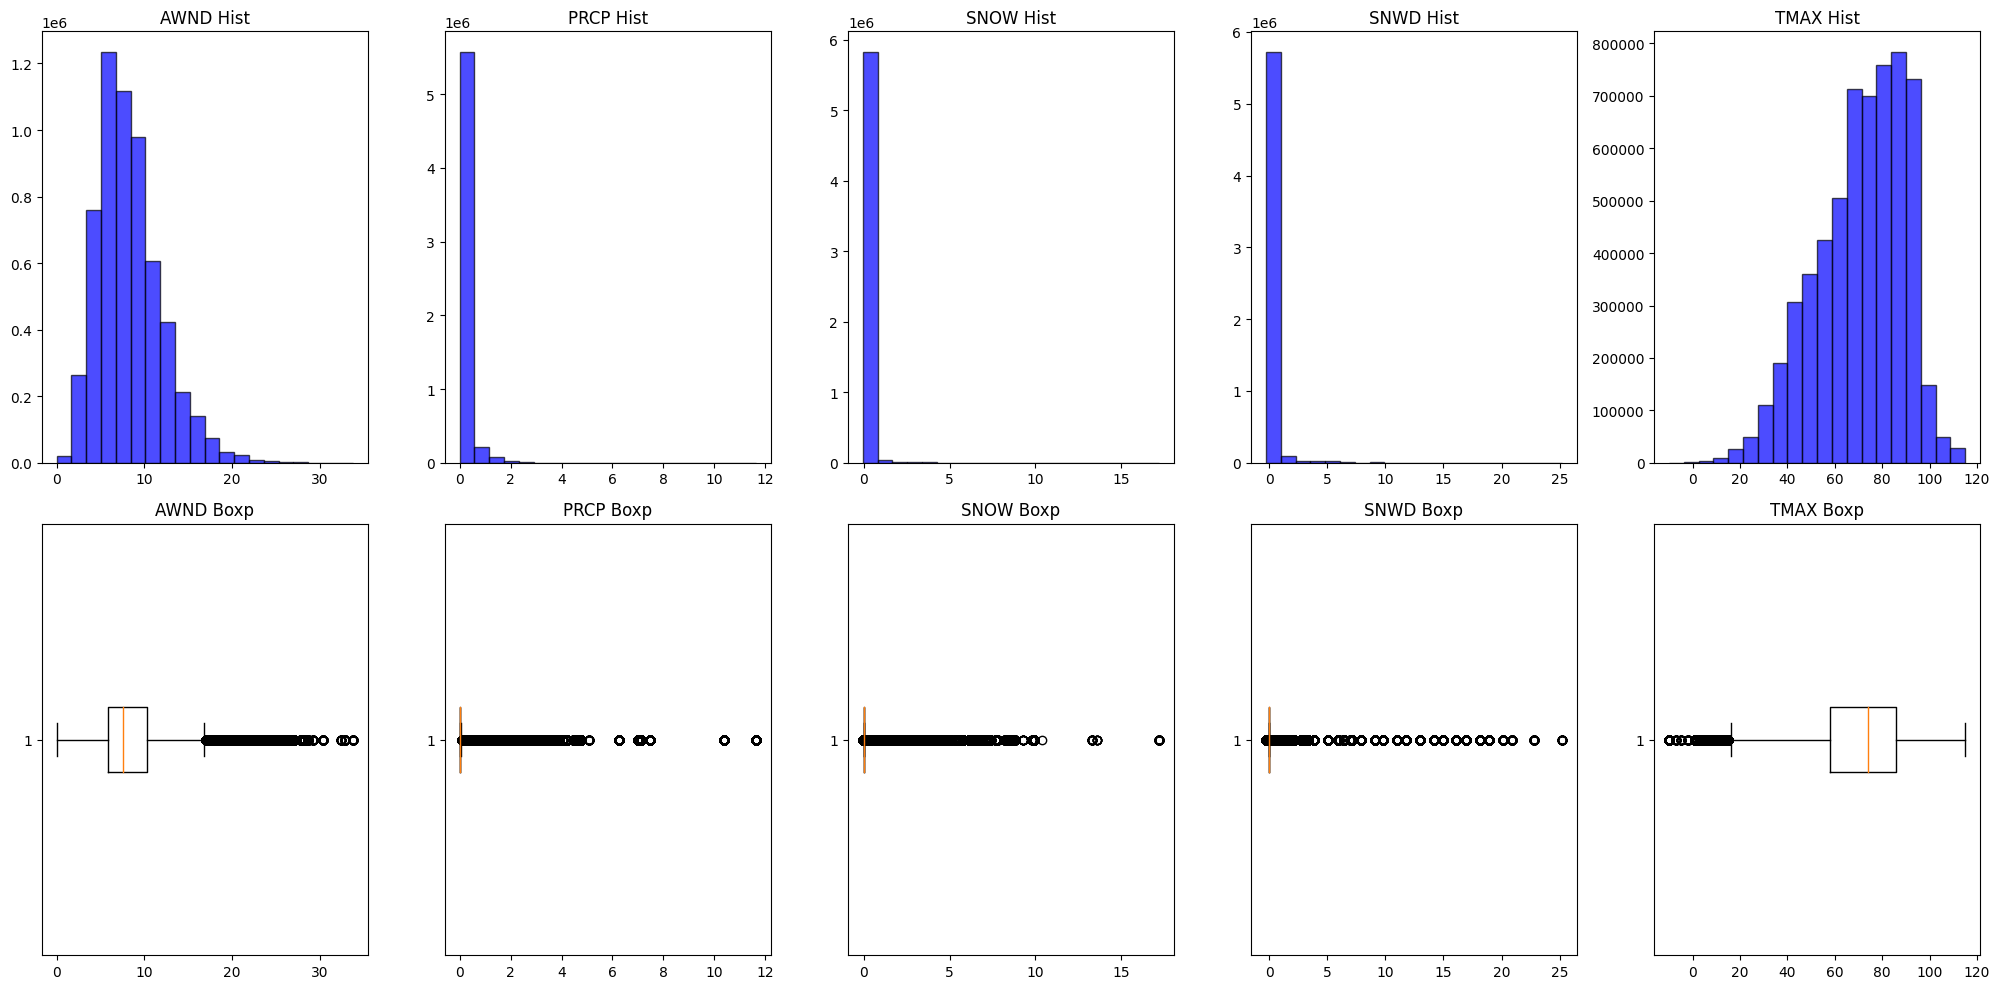

In [63]:
#Visualizing weather related distributions + boxplot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # 1 rows, 5 columns
axs = axs.flatten()

columns = ontime_reporting_export.loc[:,["AWND","PRCP","SNOW","SNWD","TMAX"]]

for i, col in enumerate(columns):
    axs[i].hist(ontime_reporting_export[col], bins=20, color='blue', alpha=0.7, ec='black')
    axs[i].set_title(col + ' Hist')

for i, col in enumerate(columns):
    axs[i + len(columns.columns)].boxplot(ontime_reporting_export[col], vert=False)
    axs[i + len(columns.columns)].set_title(col + ' Boxp')

plt.tight_layout()
plt.show()

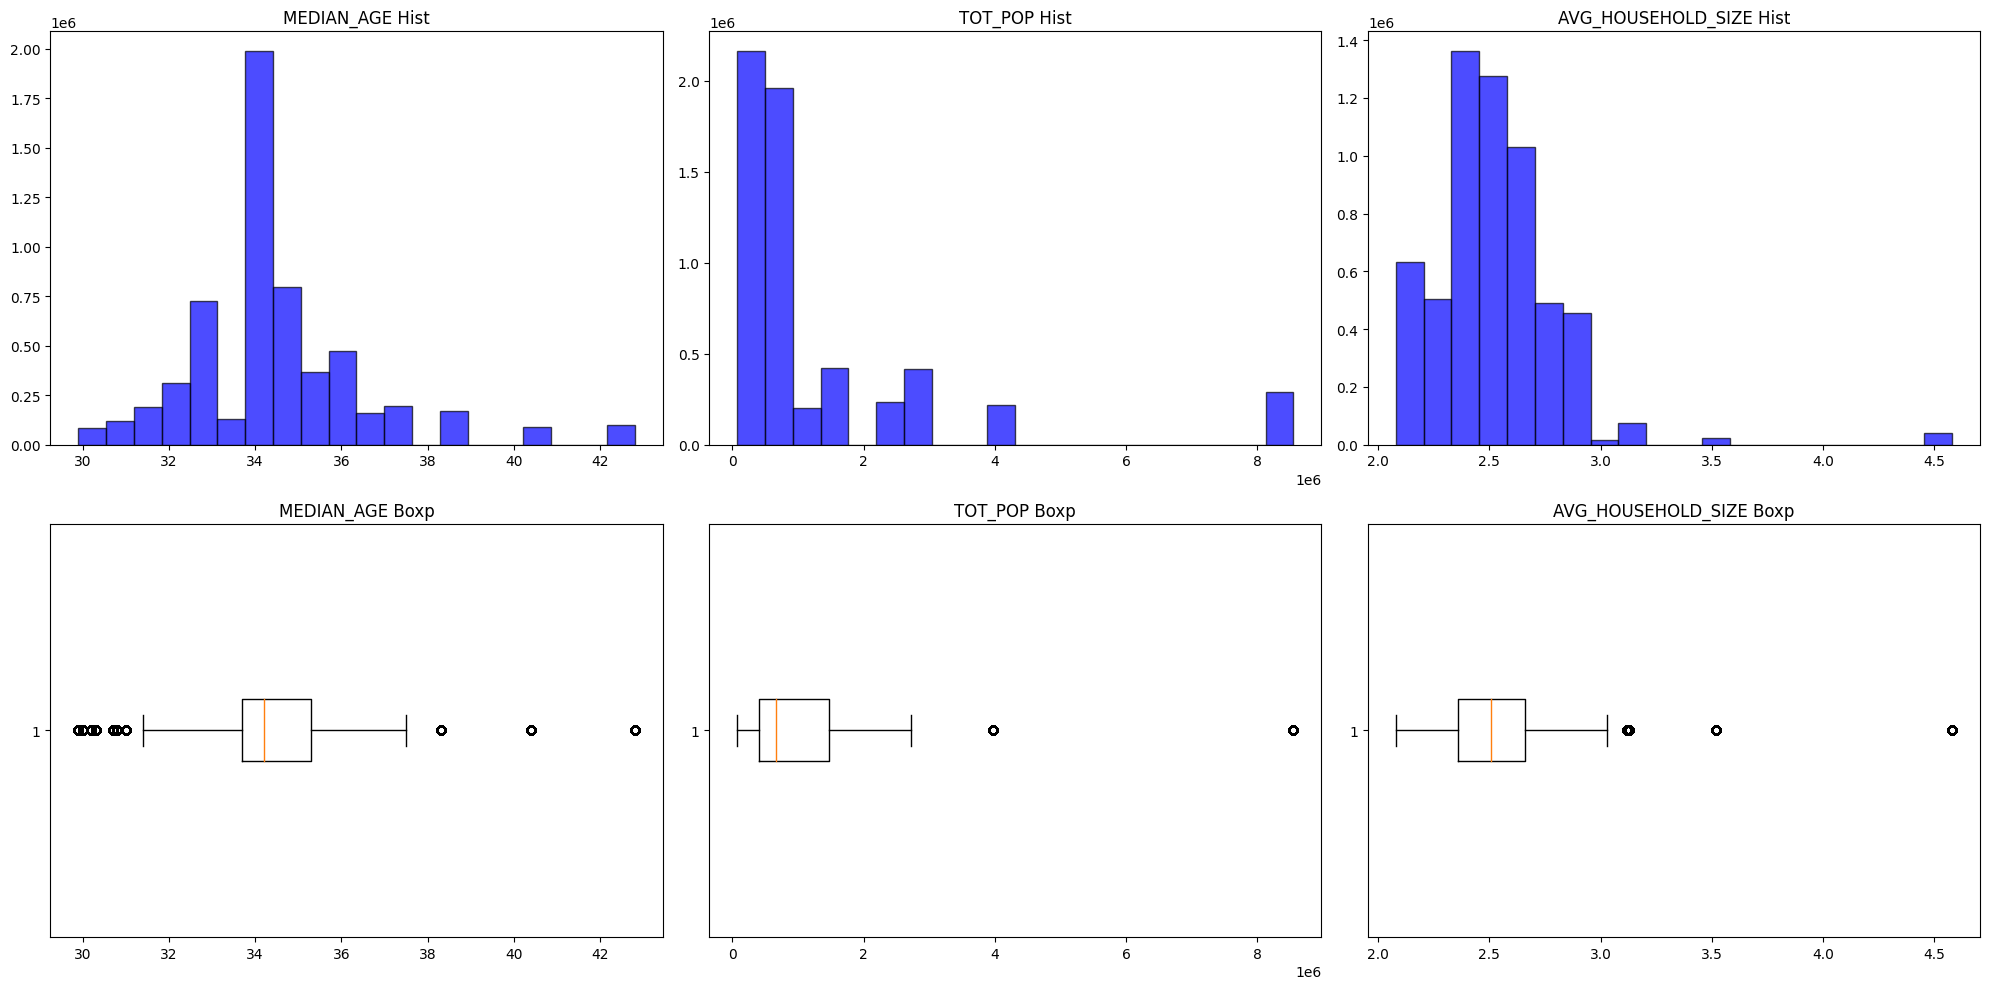

In [20]:
#Visualizing city related distributions + boxplot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows, 3 columns
axs = axs.flatten()

columns = ontime_reporting_export.loc[:,["MEDIAN_AGE","TOT_POP","AVG_HOUSEHOLD_SIZE"]]

for i, col in enumerate(columns):
    axs[i].hist(ontime_reporting_export[col], bins=20, color='blue', alpha=0.7, ec='black')
    axs[i].set_title(col + ' Hist')

for i, col in enumerate(columns):
    axs[i + len(columns.columns)].boxplot(ontime_reporting_export[col], vert=False)
    axs[i + len(columns.columns)].set_title(col + ' Boxp')

plt.tight_layout()
plt.show()

# 3. Feature Engineering

In [29]:
#Feature Enginering of "Previous_flight_delayed"
ontime_reporting_export = ontime_reporting_export.sort_values(['MONTH', 'DAY_OF_MONTH', 'TAIL_NUM', 'CRS_DEP_TIME'])
ontime_reporting_export["PREV_FLIGHT_DELAY"] = 0
ontime_reporting_export.loc[(ontime_reporting_export["TAIL_NUM"] == ontime_reporting_export["TAIL_NUM"].shift(1)) & (ontime_reporting_export["DEP_DEL15"].shift(1) == True), "PREV_FLIGHT_DELAY"] = 1

In [30]:
#Airplane age: build year - 2019
ontime_reporting_export['PLANE_AGE'] = 2019 - ontime_reporting_export['MANUFACTURE_YEAR']
ontime_reporting_export = ontime_reporting_export.drop(columns=["MANUFACTURE_YEAR"])

In [31]:
#Dropping redudant and meaningless features used for merging and feature engineering
ontime_reporting_export = ontime_reporting_export.drop(columns=["TAIL_NUM", "ORIGIN_CITY_NAME", "ORIGIN_AIRPORT_ID"])

In [32]:
pd.set_option('display.max_columns', None)
ontime_reporting_export.head(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,CRS_DEP_TIME,DEP_DEL15,CRS_ARR_TIME,DISTANCE_GROUP,NUMBER_OF_SEATS,AWND,PRCP,SNOW,SNWD,TMAX,MEDIAN_AGE,TOT_POP,AVG_HOUSEHOLD_SIZE,ORIGIN_LAT,ORIGIN_LONG,DEST_LAT,DEST_LONG,PREV_FLIGHT_DELAY,PLANE_AGE
5312428,1,1,2,G4,1805,0,2040,5,143,7.61,0.00,0.0,0.0,35.0,32.1,195099,2.56,42.8808,-85.5228,27.9102,-82.6874,0,12
5578407,1,1,2,G4,1033,1,1350,4,143,8.28,0.00,0.0,0.0,40.0,30.7,201965,2.50,36.2819,-94.3068,28.7776,-81.2375,0,12
5579069,1,1,2,G4,1711,0,2058,5,143,10.29,0.00,0.0,0.0,20.0,34.5,210317,2.41,41.5340,-93.6631,28.7776,-81.2375,0,12
5576472,1,1,2,G4,1911,0,2143,5,143,7.61,0.00,0.0,0.0,35.0,32.1,195099,2.56,42.8808,-85.5228,28.7776,-81.2375,0,12
5574941,1,1,2,G4,1215,0,1359,3,143,5.14,0.03,0.0,0.0,60.0,33.1,185312,2.21,35.8110,-83.9940,26.9202,-81.9905,0,12


<AxesSubplot: >

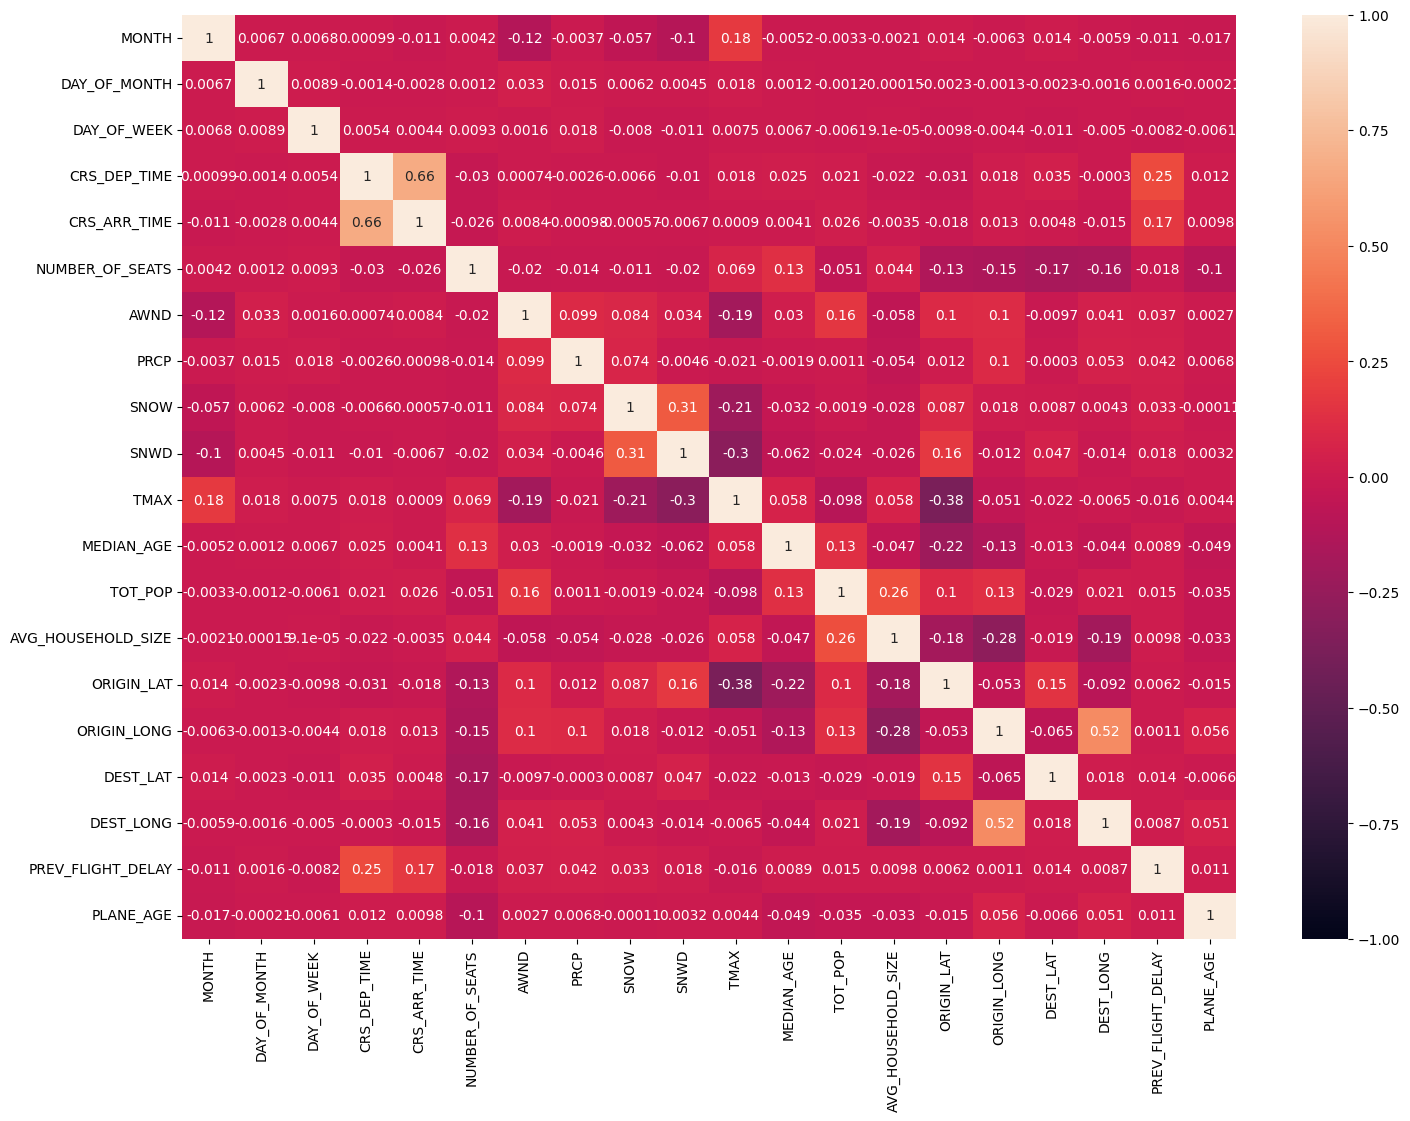

In [33]:
plt.figure(figsize=(17, 12))
sns.heatmap(ontime_reporting_export.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)

## 4. Exporting clean data

In [35]:
#Exporting the cleaned dataset
ontime_reporting_export.to_csv(path_import_and_export + "ontime_reporting_clean_export.csv", index=False)